In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
from urllib.parse import urlencode
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [139]:
# зададим параметры для визуализации
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
         )

## Оглавление

* [Задание 1 A/B тесты](#Задание-1)
    * [EDA](#EDA)
    * [Выбор метрики](#Выбор_метрики)
    * [Рассчет конверсии](#Конверсия)
    * [Рассчет прокси метрики - Bootstrap](#Bootstrap)
    * [Выводы по A/B тесту](#Выводы)
* [Задание 2 SQL](#SQL)
    * [Задача 1](#SQL1)
    * [Задача 2](#SQL2)
* [Задание 3 Функции](#задание3)
    * [Задача 1](#def1)
    * [Задача 2](#def2)

# Задание 1 <a class="anchor" id="Задание-1"></a>

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
В качестве входных данных имееv 4 csv-файла:
1. [groups.csv](https://disk.yandex.ru/d/UhyYx41rTt3clQ) - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

2. [groups_add.csv](https://disk.yandex.ru/d/5Kxrz02m3IBUwQ) - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

3. [active_stats](https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ)- файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

4. [checks.csv](https://disk.yandex.ru/d/pH1q-VqcxXjsVA)- файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Загрузим данные с яндекс диска

In [140]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_stats = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
sep = ';'

def load_data_from_yd(base_url: str, url: str, sep: str) -> pd.DataFrame:
    ''' Function for downloading data from yandex.disk'''
    final_url = base_url + urlencode(dict(public_key= url))
    res_df = pd.read_csv(requests.get(final_url).json()['href'], sep= sep)
    return res_df

df_groups = load_data_from_yd(base_url=base_url, url=groups, sep=sep)
df_groups_add = load_data_from_yd(base_url=base_url, url=groups_add, sep=',')
df_active_stats = load_data_from_yd(base_url=base_url, url=active_stats, sep=sep)
df_checks = load_data_from_yd(base_url=base_url, url=checks, sep=sep)


"\nbase_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' \ngroups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'\ngroups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'\nactive_stats = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'\nchecks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'\n\nfinal_url_groups = base_url + urlencode(dict(public_key= groups)) \nfinal_url_groups_add = base_url + urlencode(dict(public_key= groups_add))\nfinal_url_key_active_stats = base_url + urlencode(dict(public_key= active_stats))\nfinal_url_key_checks = base_url + urlencode(dict(public_key= checks))\n\ndf_groups = pd.read_csv(requests.get(final_url_groups).json()['href'], sep= ';')\ndf_groups_add = pd.read_csv(requests.get(final_url_groups_add).json()['href'], sep= ',')\ndf_active_stats = pd.read_csv(requests.get(final_url_key_active_stats).json()['href'], sep= ';')\ndf_checks = pd.read_csv(requests.get(final_url_key_checks).json()['href'], sep= ';')\n\n"

## Разведочный анализ данных <a class="anchor" id="EDA"></a>


In [141]:
df_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [142]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [143]:
df_groups.id.nunique()

74484

In [144]:
df_groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Видим, что количество наблюдений в группах сильно отличается, учтем это при выборе статистического теста. 

In [145]:
df_groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [146]:
df_groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [147]:
df_groups_add.id.nunique()

92

In [148]:
df_groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

Добавим дополнительный файл df_groups_add к основному df_groups

In [149]:
df_groups_full = pd.concat([df_groups, df_groups_add], ignore_index= True)

In [150]:
df_groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [151]:
df_active_stats.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [152]:
df_active_stats.student_id.nunique()

8341

In [153]:
df_active_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


Приведем название колонок к единому стилю 

In [154]:
df_active_stats = df_active_stats.rename(columns={'student_id': 'id'})

In [155]:
df_checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [156]:
df_checks = df_checks.rename(columns={'student_id': 'id'})

In [157]:
df_checks.id.nunique()

541

In [158]:
df_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


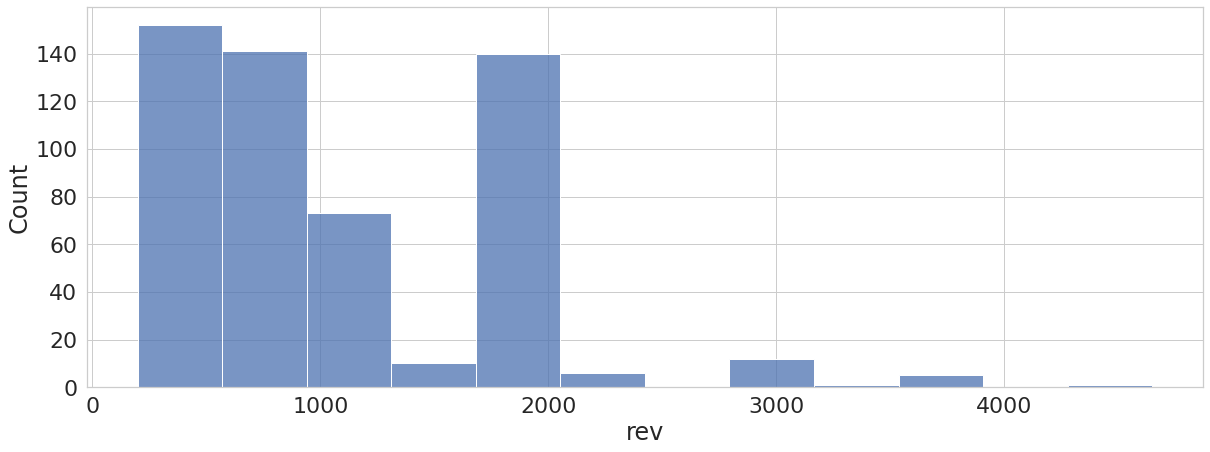

In [159]:
sns.histplot(df_checks.rev)
None

Распределение оплат пользователей явно бимодально, пердстоит выяснить связано ли это с влиянием экспериментальной группы или оно бимодально априори. 

In [160]:
df_checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Соберем в одну табличку активных пользователей и их оплаты. Nan в оплатах заменем на 0. НЕ АКТИВНЫЕ пользователи, которые оплату ОРТБРАСЫВАЮТСЯ при джойне таблицы df_active_stats к таблице df_groups_full. 

In [187]:
df = df_groups_full.merge(df_active_stats, on= 'id', how= 'right').merge(df_checks, how= 'left', on= 'id').fillna(0)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     8341 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [181]:
df['rev'] = df.rev.astype('int')

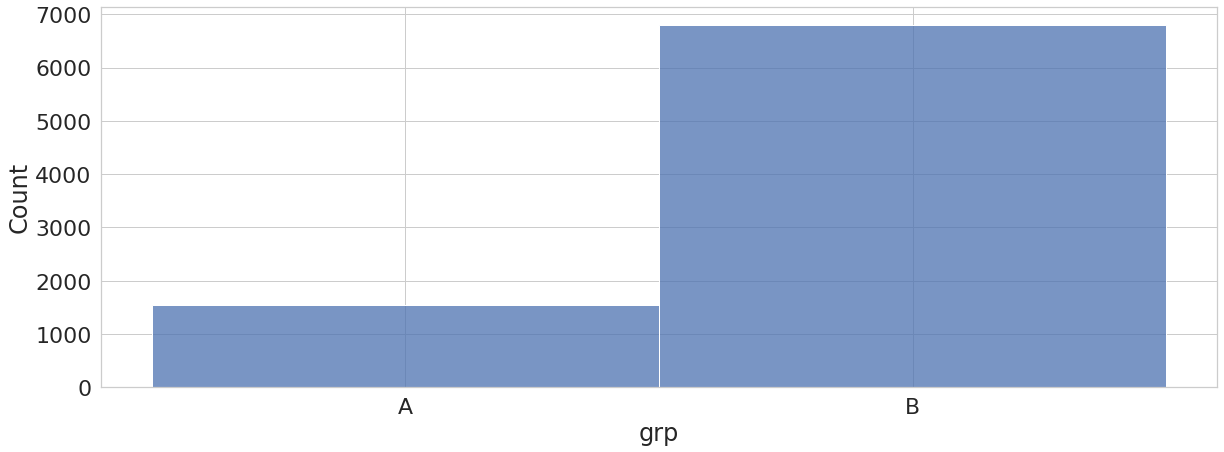

In [182]:
sns.histplot(df.grp)
None

Видим, что распределение по группам пользователей в дни теста, практически не отличается от распределения по группам всех пользователей.

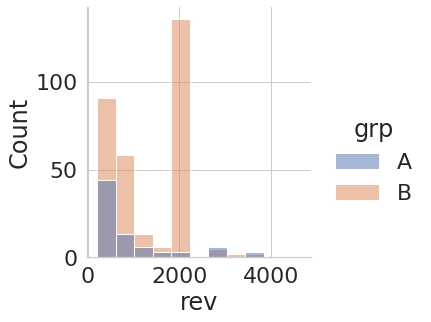

In [183]:
sns.displot(x= 'rev', data= df.query('rev > 0'), hue= 'grp')
None

Распределение по размеру среднего чека силльно различается в тестовой и целевой группе.

## Выбор метрики <a class="anchor" id="Выбор_метрики"></a>

За целевую метрику примем конверсию в оплату(cr), т.к. наша задача - определить разницу между стандартной механикой оплаты услуг и измененной.
Нулевая гипотеза Н0: конверсия с новой механикой оплаты услуг не изменилась. H1:конверсия с новой механикой оплаты услуг изменилась. 
В качестве статистического теста будем использовать критерий Хи-квадрат.

Второй метрикой рассчитаем arppu. 
Нулевая гипотеза Н0: arppu с новой механикой остался неизменным. H1: arppu с новой механикой оплаты услуг изменился.
В качетве статистического теста будем использовать бутстрап, т.к. есть серьезный перекос по количеству пользвователей в тестовой выборке и целевой.

In [62]:
df

,id,grp,rev
0,581585,A,0
1,5723133,A,0
2,3276743,B,0
3,4238589,A,0
4,4475369,B,0
...,...,...,...
8336,1794344,B,0
8337,296883,B,0
8338,3598448,B,0
8339,3610547,B,290


## Рассчет конверсии <a class="anchor" id="Конверсия"></a>

Для рассчета соберем таблицу сопряженности 

In [184]:
table = (df.query('rev > 0').groupby('grp', as_index= False)
                            .agg({'rev': 'count'}).rename(columns = {'rev': 'pay'})
                            .merge(df.query('rev == 0').groupby('grp', as_index= False)
                            .agg({'rev': 'count'}).rename(columns = {'rev': 'no_pay'}), on= 'grp'))

In [185]:
table

,grp,pay,no_pay
0,A,78,1460
1,B,314,6489


In [65]:
contingency_table = table.pivot_table(columns= 'grp', values= ['pay', 'no_pay'])

In [66]:
contingency_table

grp,A,B
no_pay,1460,6489
pay,78,314


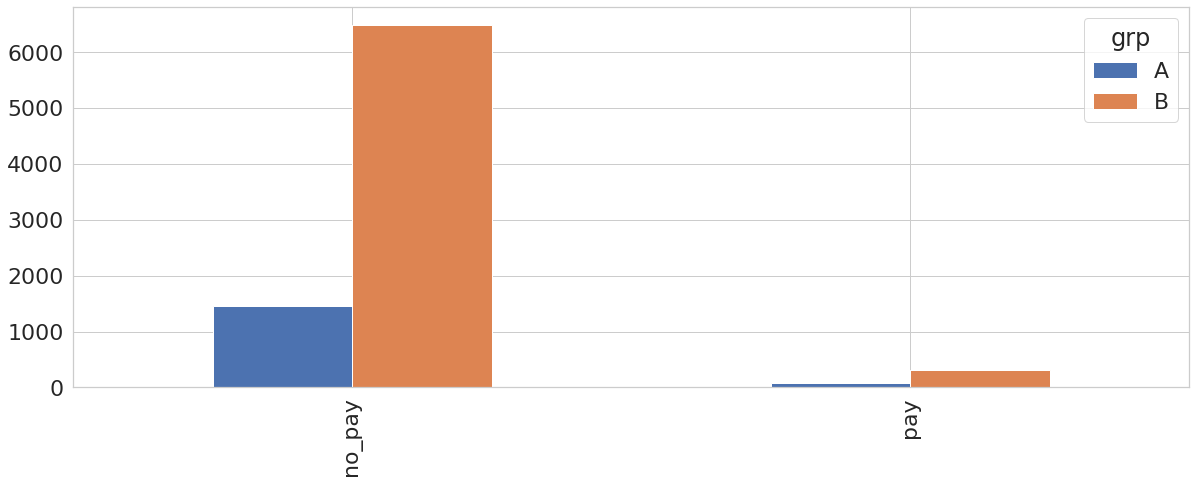

In [144]:
contingency_table.plot.bar()
None

In [145]:
def cs(n, y):
    return stats.chisquare(n, np.sum(n) / np.sum(y) * y)

In [146]:
cs(contingency_table.A, contingency_table.B)

Power_divergenceResult(statistic=0.7261217044976442, pvalue=0.39414319084770877)

Результат теста pvalue=0.39 говорит о том, что нулевая гипотез не отклоняется и между распределением тестовой группы и распределением целевой группы статистически значимой разницы нет, 
В связи с этим делаем вывод, что новая механика не увеличивает конверсию. 

## Рассчет ARPPU - Bootstrap <a class="anchor" id="Bootstrap"></a>

Проверим среднее распределений с помощью Бутстрэпа. 

In [147]:
A = df.query('rev > 0 & grp == "A"')['rev']

In [148]:
B = df.query('rev > 0 & grp == "B"')['rev']

In [154]:
mean_diff = []

for i in range(10000):
    sample_data_control= A.sample(frac=1, replace=True)
    sample_mean_control= sample_data_control.mean()
    
    
    sample_data_exp= B.sample(frac=1, replace=True)
    sample_mean_exp= sample_data_exp.mean()
    
    sample_mean_diff= sample_mean_control - sample_mean_exp
    mean_diff.append(sample_mean_diff)
    

In [155]:
pd.Series(mean_diff).quantile(0.975)

-99.06309611301641

In [156]:
pd.Series(mean_diff).quantile(0.025)

-541.6338151233056

In [157]:
A.mean()

933.5897435897435

In [158]:
B.mean()

1257.8789808917197

Видим, что разница доверительных интервалов arppu не включает 0, что говорит о статистически значимых различиях между arppu групп. Нулевая гипотеза отклоняется. Можем сделать вывод о том, что arppu с новой механикой оплаты выше, чем при старой механике.

## Выводы по A/B тесту <a class="anchor" id="Выводы"></a>

На основе проведенных статистических тестов можем сделать следующие выводы: 
1. С новой механикой конверсия не увеличивается
2. Arppu c новой механикой увеличилось.

Не смотря на приятные результаты по ARPPU, мы не можем сделать выбор в пользу новой механики оплаты, т.к. основной метрикой является конверсия в оплату, а мы определили, что она не отличается от тестовой выборки. 

### Задача 1 <a class="anchor" id="def1"></a>

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.



In [184]:
def load_new_data(base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
                    groups='https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                    groups_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                    active_stats='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                    checks='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'):
    '''
    A function for uploading data and automatically calculating metrics.
    
    '''
    
    # загрузим данные с диска
    final_url_groups= base_url + urlencode(dict(public_key= groups)) 
    final_url_groups_add= base_url + urlencode(dict(public_key= groups_add))
    final_url_key_active_stats = base_url + urlencode(dict(public_key= active_stats))
    final_url_key_checks= base_url + urlencode(dict(public_key= checks))

    df_groups= pd.read_csv(requests.get(final_url_groups).json()['href'], sep= ';')
    df_groups_add= pd.read_csv(requests.get(final_url_groups_add).json()['href'], sep= ',')
    df_active_stats = pd.read_csv(requests.get(final_url_key_active_stats).json()['href'], sep= ';')
    df_checks= pd.read_csv(requests.get(final_url_key_checks).json()['href'], sep= ';')
    
    #подготовка данных
    df_groups_full= pd.concat([df_groups, df_groups_add], ignore_index= True)
    df_active_stats= df_active_stats.rename(columns={'student_id': 'id'})
    df_checks= df_checks.rename(columns={'student_id': 'id'})
    df= df_groups_full.merge(df_active_stats, on= 'id').merge(df_checks, how= 'left', on= 'id').fillna(0)
    
    # расчет метрик 
    table= (df.query('rev > 0').groupby('grp', as_index= False)
                     .agg({'rev': 'count'}).rename(columns= {'rev': 'pay'})
                     .merge(df.query('rev == 0').groupby('grp', as_index= False)
                     .agg({'rev': 'count'}).rename(columns= {'rev': 'no_pay'}), on= 'grp'))
    table['cr']= table.pay / table.no_pay
    
    #рассчитаем arpu
    arpu = (df.groupby('grp', as_index = False).agg({'rev': 'sum'})
            .merge(df.groupby('grp', as_index = False).agg({'rev': 'count'}), on= 'grp'))
    arpu['arpu']= arpu.rev_x / arpu.rev_y
            
    #рассчитаем arppu
    arppu= (df.query('rev > 0').groupby('grp', as_index = False).agg({'rev': 'sum'})
            .merge(df.query('rev > 0').groupby('grp', as_index = False).agg({'rev': 'count'}), on= 'grp'))
    arppu['arppu']= arppu.rev_x / arppu.rev_y   
    
    return table[['grp','cr']], arpu[['grp','arpu']], arppu[['grp','arppu']]

In [185]:
z, x, c = load_new_data()

### Задача 2 <a class="anchor" id="def2"></a>
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [207]:
def plots(table: pd.DataFrame, arpu: pd.DataFrame, arppu: pd.DataFrame):
    '''
    A function for drawing diagrams by basic metrics (cr, arpu, arppu)
    
    '''
    fig, axs = plt.subplots(nrows= 1, ncols= 3, figsize= (20, 10), sharey= 'col', sharex= True)

    for name, ax in zip(['cr', 'arpu', 'arppu'], axs.flatten()):
        ax.set(title=f'График {name}')
        ax.tick_params(labelbottom= True, which= 'both')

    axs[0].bar(table.grp, table['cr'])
    axs[1].bar(arpu.grp, arpu['arpu'])
    axs[2].bar(arppu.grp, arppu['arppu'])


    fig.suptitle('Метрики')
    plt.show()

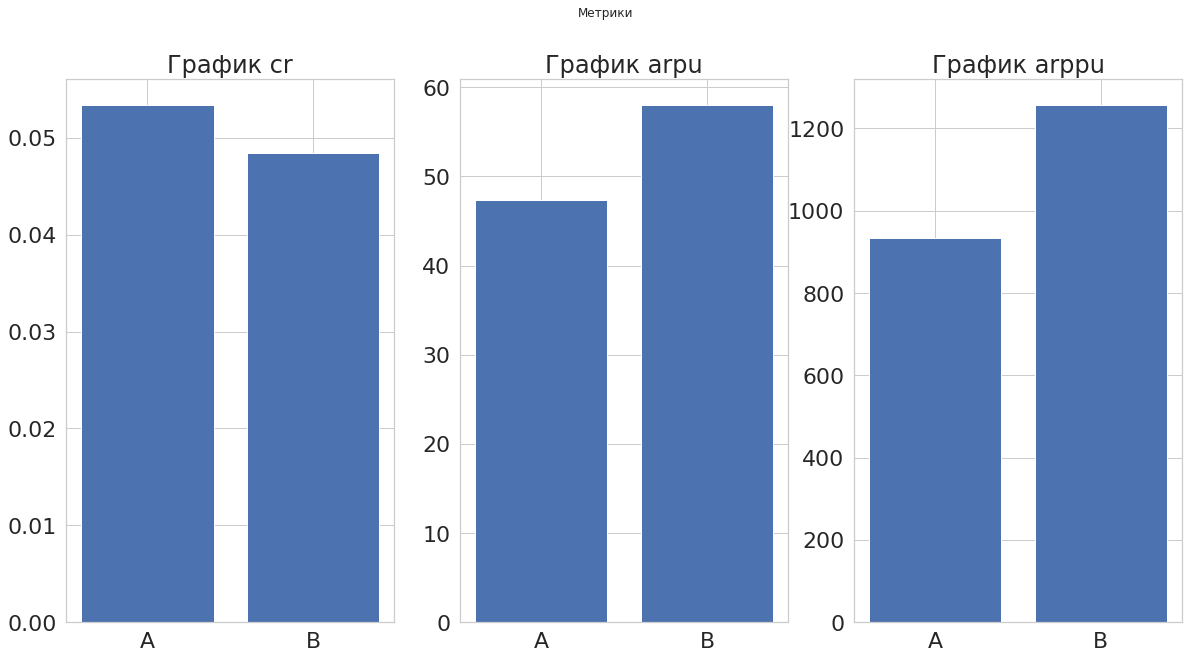

In [208]:
plots(z, x, c)